In [132]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [42]:
S = 300
K = 300
r = 0.05
T = 1

$H = 0.5$

fBs Monte Carlo

In [43]:
from pricing.fBs import FractionalBlackScholes
from pricing.price_engine import MontelCarloOptionPricingEngine

fBs = FractionalBlackScholes()
pricer = MontelCarloOptionPricingEngine(fBs)

fBs.set_parameters(mu=r, sigma=0.15, h=0.5)

size = 1001

price = pricer.european_call_option_price(S, K, r, T, size, batch_num=10)
print(price)

Finsihed  100.00%
25.761094217180716


BS Monte Carlo

In [45]:
from pricing.blackscholes import BlackScholes

bs = BlackScholes()
pricer = MontelCarloOptionPricingEngine(bs)

S = 300
K = 300
r = 0.05
T = 1

fBs.set_parameters(mu=r, sigma=0.15)

size = 1001

price = pricer.european_call_option_price(S, K, r, T, size, batch_num=10)
print(price)

Finsihed  100.00%
25.824064323902498


Theoretical Value

In [48]:
from pricing.price_engine import blackscholes_call
from pricing.fBs import fbs_call

print(blackscholes_call(S, K, T, r, 0.15))
print(fbs_call(S, K, T, r, 0.5, 0.15))

25.774974936267512
25.774974936267512


$H = 0.25$

fBs Monte Carlo

In [61]:
fBs = FractionalBlackScholes()
pricer = MontelCarloOptionPricingEngine(fBs)

fBs.set_parameters(mu=r, sigma=0.15, h=0.75)

size = 10001
T = 0.1

pricer.generator = None
price = pricer.european_call_option_price(S, K, r, T, size, batch_num=10)
print(price)

Finsihed  100.00%
4.03104512884582


Theoretical Value

In [59]:
print(fbs_call(S, K, T, r, 0.7, 0.15))

4.370777618820426


In [63]:
fBs = FractionalBlackScholes()
pricer = MontelCarloOptionPricingEngine(fBs)

fBs.set_parameters(mu=r, sigma=0.15, h=0.25)

size = 10001
T = 0.05

price = pricer.european_call_option_price(S, K, r, T, size, batch_num=10)
print(price)

Finsihed  100.00%
0.0009224894673068029


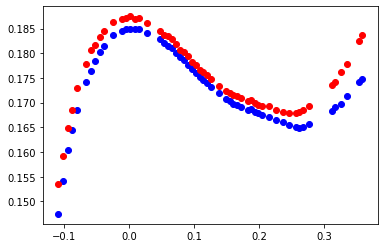

In [128]:
import yfinance as yf
from datetime import date, datetime, timedelta
from pricing.price_engine import find_implied_vol_curve

spx = yf.Ticker("^SPX")

expiry_date = date(2022, 12, 16)
start_date = date(2022, 6, 15)

spx_option_data = spx.option_chain(expiry_date.strftime('%Y-%m-%d')).calls
spx_option_data = spx_option_data[
    (spx_option_data['lastTradeDate'] >= start_date.strftime('%Y-%m-%d')) & 
    (spx_option_data['strike'] > 3000) &
    (spx_option_data['strike'] < 5500)
]
Ks = spx_option_data['strike'].to_numpy()
real_bids = spx_option_data['bid'].to_numpy()
real_asks = spx_option_data['ask'].to_numpy()

r = 0.04791
S0 = spx.history()['Close'][0]
T = (expiry_date - start_date) / timedelta(days=365)

log_Ks = np.log(Ks / S0)
real_bids_implied_vol = find_implied_vol_curve(S0,T,r, Ks, real_bids)
real_asks_implied_vol = find_implied_vol_curve(S0,T,r, Ks, real_asks)

plt.scatter(log_Ks, real_bids_implied_vol, color='blue')
plt.scatter(log_Ks, real_asks_implied_vol, color='red')
plt.show()

In [100]:
from skopt import gp_minimize, callbacks
from skopt.space import Real
from skopt.utils import use_named_args

dimension_sigma = Real(name='sigma', low=0.001, high=5)
dimension_h = Real(name='h', low=0.001, high=0.999)
dim = [dimension_sigma, dimension_h]

@use_named_args(dimensions=dim)
def fbs_calibrate_1(sigma, h):
    prices = map(lambda k: fbs_call(S0, k, T, r, h, sigma), Ks)
    prices = np.fromiter(prices, dtype=np.float64)
    curve = find_implied_vol_curve(S0, T, r, Ks, prices)
    diff = (curve - real_bids_implied_vol)**2
    diff += (curve - real_asks_implied_vol)**2

    return np.sum(diff)

checkpoint_saver = callbacks.CheckpointSaver(
    './CheckpointSaver/fbs_checkpoint1.pkl', 
    compress=9
)

result = gp_minimize(
    fbs_calibrate_1,
    dim,
    x0=[0.2, 0.5],
    callback=[checkpoint_saver],
    verbose=True
)

Iteration No: 1 started. Evaluating function at provided point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 0.0198
Function value obtained: 0.0420
Current minimum: 0.0420
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0174
Function value obtained: 343.1454
Current minimum: 0.0420
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0176
Function value obtained: 105.7350
Current minimum: 0.0420
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0175
Function value obtained: 92.2884
Current minimum: 0.0420
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0181
Function value obtained: 121.7039
Current minimum: 0.0420
Iteration No: 6 started.

In [110]:
opt_sigma = result.x[0]
opt_h = result.x[1]

print(result.x)

[0.269975001869611, 0.9888305490478808]


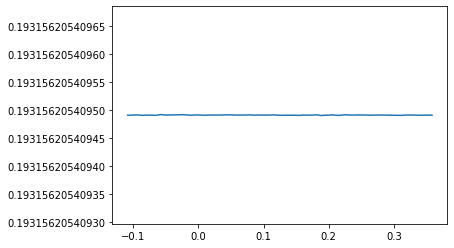

In [124]:
prices = map(lambda k: fbs_call(S0, k, T, r, opt_h, opt_sigma), Ks)
prices = np.fromiter(prices, dtype=float)

def fbs_calibrate_12(sigma, h):
    prices = map(lambda k: fbs_call(S0, k, T, r, h, sigma), Ks)
    prices = np.fromiter(prices, dtype=float)
    curve = find_implied_vol_curve(S0, T, r, Ks, prices)
    diff = (curve - real_bids_implied_vol)**2
    diff += (curve - real_asks_implied_vol)**2

    return np.sum(diff)

plt.plot(log_Ks, find_implied_vol_curve(S0, T, r, Ks, prices))
plt.show()

In [236]:
from fbm.sim import DaviesHarteFBmGenerator
from fbm.sim import HoskingFBmGenerator
Hs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

S0 = 300
K = S0
r = 0.05
T = 0.5
sigma = 0.2

fBs = FractionalBlackScholes()
fBs.set_parameters(mu=r, sigma=sigma)
pricer.generator = None

dh = DaviesHarteFBmGenerator()

monte_prices = dict()
for h in Hs:
    fBs.set_parameters(h=h)
    # pricer = MontelCarloOptionPricingEngine(fBs)
    monte_prices[h] = list()
    for _ in range(30):
        num = 10000
        ss = np.ndarray(num)
        for i in range(num):
            ss[i] = (dh.generate_fBm(H=h, size=1001, T=T)[-1])

        s = S0*np.exp(r*T - sigma**2/2*T**(2*h) + sigma*ss)
        c = np.maximum(s - S0, 0)
        c *= np.exp(-r*T)
            
        p = np.average(c)

        monte_prices[h].append(p)
    print(f"Finish {h}")

Finish 0.1
Finish 0.2
Finish 0.3
Finish 0.4
Finish 0.5
Finish 0.6
Finish 0.7
Finish 0.8
Finish 0.9


In [262]:
from fbm.utils import load_pickel

monte_prices = load_pickel('./findings/fBs/sde_solution_mc_method')
monte_prices

{0.1: [26.51713053269476,
  26.010892360461714,
  25.888987817703995,
  25.844362380359485,
  25.378848595052208,
  25.931945893363025,
  26.24126453271273,
  25.108794078281782,
  26.709042136691174,
  25.940495472685683,
  25.958266211602588,
  26.204531642847193,
  25.77378744161823,
  25.241627171165803,
  25.657309408574605,
  26.140728302958813,
  25.482167406466726,
  26.205107254242836,
  25.407135693854233,
  25.958315549366297,
  26.097599806555912,
  25.90729294717466,
  26.102927491622925,
  26.139910919849953,
  25.83581108879057,
  26.176313403558083,
  26.12966468938756,
  26.228286651389904,
  25.129860983535853,
  26.210605434243426],
 0.2: [24.270612350471453,
  23.931299688209634,
  24.377703088249113,
  24.384414417801246,
  24.415978523534765,
  24.79831818109482,
  24.316021364587048,
  24.390070769390988,
  24.47093745106493,
  23.357883405198372,
  24.724439538031557,
  24.23611560566434,
  24.503004359151337,
  24.493231298202307,
  24.55078736357129,
  24.9001

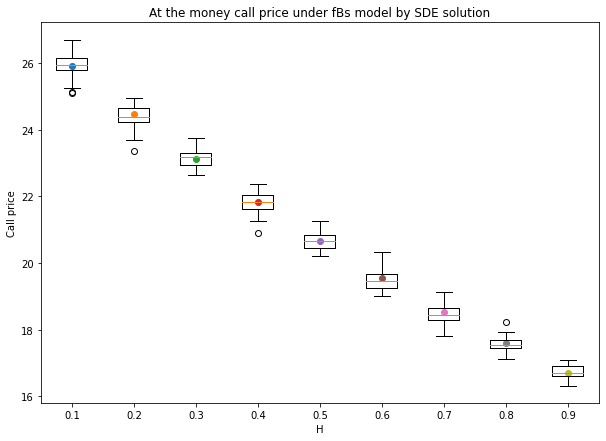

In [263]:
fig, ax = plt.subplots(figsize=(10,7))
columns = [monte_prices[k] for k in monte_prices.keys()]
ax.boxplot(columns)
for ind, h in enumerate(Hs):
    theoretical_price = fbs_call(S0, S0, T, r, h, sigma)
    ax.scatter(ind+1, theoretical_price)

ax.set_xlabel('H')
ax.set_ylabel('Call price')
ax.set_title('At the money call price under fBs model by SDE solution')

plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], Hs)
plt.show()

In [241]:
def fbs_stock_price(S0, r, sigma, T, h, size, sim_num):
    result = np.zeros((sim_num, size))
    generator = DaviesHarteFBmGenerator()
    for i in range(sim_num):
        result[i] = generator.generate_fBm(h, size, T)
    for i in range(size):
        t = i / size * T
        result[:,i] = S0*np.exp(r*t - sigma**2/2*t**(2*h) + sigma*result[:,i])

    return result    

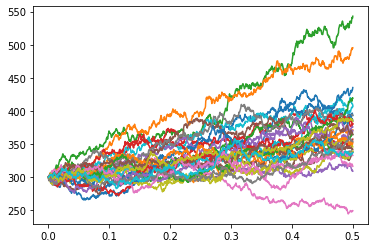

In [249]:
paths = fbs_stock_price(300, 0.5, 0.2, 0.5, 0.5, 1001, 30)
for p in paths:
    plt.plot(np.linspace(0, 0.5, 1001), p)
plt.show()

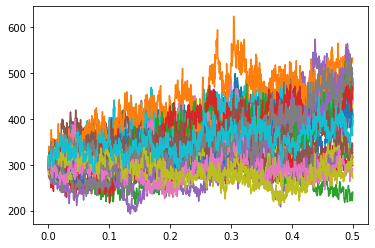

In [250]:
paths = fbs_stock_price(300, 0.5, 0.2, 0.5, 0.2, 1001, 30)
for p in paths:
    plt.plot(np.linspace(0, 0.5, 1001), p)
plt.show()

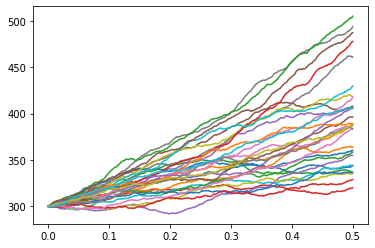

In [253]:
paths = fbs_stock_price(300, 0.5, 0.2, 0.5, 0.8, 1001, 30)
for p in paths:
    plt.plot(np.linspace(0, 0.5, 1001), p)
plt.show()

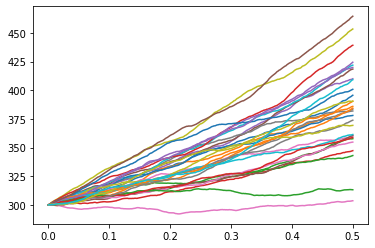

In [252]:
paths = fbs_stock_price(300, 0.5, 0.2, 0.5, 0.9, 1001, 30)
for p in paths:
    plt.plot(np.linspace(0, 0.5, 1001), p)
plt.show()

In [255]:
from fbm.utils import BackupHelper

montecarlo_prices_backup = BackupHelper('./findings/fBs', 'sde_solution_mc_method')
montecarlo_prices_backup.dump(monte_prices)

In [265]:
from fbm.sim import DaviesHarteFBmGenerator
from fbm.sim import HoskingFBmGenerator
Hs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

S0 = 300
K = S0
r = 0.05
T = 0.5
sigma = 0.2

fBs = FractionalBlackScholes()
fBs.set_parameters(mu=r, sigma=sigma)
pricer = MontelCarloOptionPricingEngine(fBs)
pricer.generator = None

dh = DaviesHarteFBmGenerator()

monte_prices = dict()
for h in Hs:
    # pricer = MontelCarloOptionPricingEngine(fBs)
    monte_prices[h] = list()
    for _ in range(30):
        p = pricer.european_call_option_price(
            S0, np.array([K]), r, T, size=1001, batch_num=1, quiet=True, h=h
        )
        monte_prices[h].append(p)
    print(f"Finish {h}")

Finish 0.1
Finish 0.2
Finish 0.3
Finish 0.4
Finish 0.5
Finish 0.6
Finish 0.7
Finish 0.8
Finish 0.9


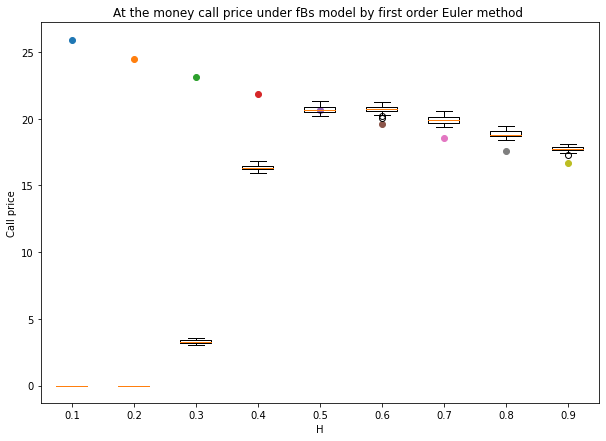

In [266]:
fig, ax = plt.subplots(figsize=(10,7))
columns = [monte_prices[k] for k in monte_prices.keys()]
ax.boxplot(columns)
for ind, h in enumerate(Hs):
    theoretical_price = fbs_call(S0, S0, T, r, h, sigma)
    ax.scatter(ind+1, theoretical_price)

ax.set_xlabel('H')
ax.set_ylabel('Call price')
ax.set_title('At the money call price under fBs model by first order Euler method ')

plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], Hs)
plt.show()

Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating 

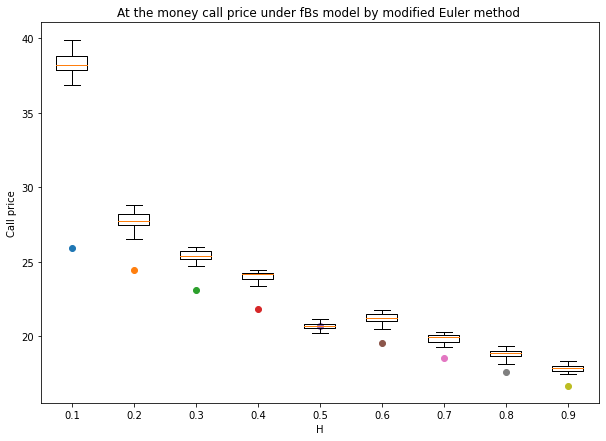

In [272]:
from fbm.sim import DaviesHarteFBmGenerator
from fbm.sim import HoskingFBmGenerator
Hs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

S0 = 300
K = S0
r = 0.05
T = 0.5
sigma = 0.2

fBs = FractionalBlackScholes()
fBs.set_parameters(mu=r, sigma=sigma)
pricer = MontelCarloOptionPricingEngine(fBs)
pricer.generator = None

dh = DaviesHarteFBmGenerator()

monte_prices = dict()
for h in Hs:
    # pricer = MontelCarloOptionPricingEngine(fBs)
    monte_prices[h] = list()
    for _ in range(30):
        p = pricer.european_call_option_price(
            S0, np.array([K]), r, T, size=4096, batch_num=1, verbose=True, h=h
        )
        monte_prices[h].append(p)
    print(f"Finish {h}")

fig, ax = plt.subplots(figsize=(10,7))
columns = [monte_prices[k] for k in monte_prices.keys()]
ax.boxplot(columns)
for ind, h in enumerate(Hs):
    theoretical_price = fbs_call(S0, S0, T, r, h, sigma)
    ax.scatter(ind+1, theoretical_price)

ax.set_xlabel('H')
ax.set_ylabel('Call price')
ax.set_title('At the money call price under fBs model by modified Euler method ')

plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], Hs)
plt.show()

Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating  99.99% dwh
Running batch 1/1
fBS: Simulating 

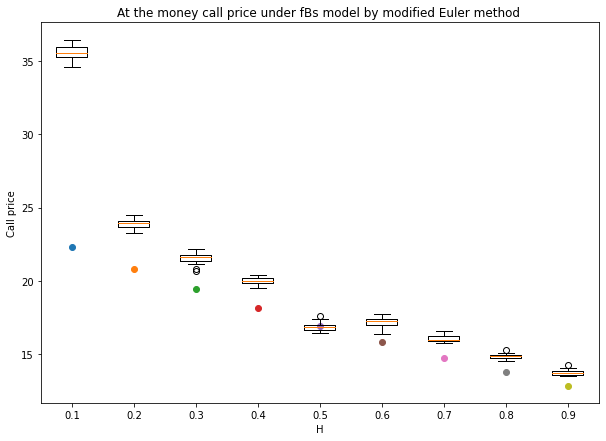

In [273]:
from fbm.sim import DaviesHarteFBmGenerator
from fbm.sim import HoskingFBmGenerator
Hs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

S0 = 300
K = S0
r = 0
T = 0.5
sigma = 0.2

fBs = FractionalBlackScholes()
fBs.set_parameters(mu=r, sigma=sigma)
pricer = MontelCarloOptionPricingEngine(fBs)
pricer.generator = None

dh = DaviesHarteFBmGenerator()

monte_prices = dict()
for h in Hs:
    # pricer = MontelCarloOptionPricingEngine(fBs)
    monte_prices[h] = list()
    for _ in range(30):
        p = pricer.european_call_option_price(
            S0, np.array([K]), r, T, size=4096, batch_num=1, verbose=True, h=h
        )
        monte_prices[h].append(p)
    print(f"Finish {h}")

fig, ax = plt.subplots(figsize=(10,7))
columns = [monte_prices[k] for k in monte_prices.keys()]
ax.boxplot(columns)
for ind, h in enumerate(Hs):
    theoretical_price = fbs_call(S0, S0, T, r, h, sigma)
    ax.scatter(ind+1, theoretical_price)

ax.set_xlabel('H')
ax.set_ylabel('Call price')
ax.set_title('At the money call price under fBs model by modified Euler method ')

plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], Hs)
plt.show()